<a href="https://colab.research.google.com/github/AlexAlexeyuk/Alexander.Alexeyuk/blob/ready/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%B8_%D0%B2%D1%8B%D0%B2%D0%BE%D0%B4%D1%8B_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Цель обучения моделей: 
* Построить модель, которая смогла бы минимизировать количество назначенных антибиотиков при нулевом уровне ложноотрицательных результатов
## Задачи:
* Построить наиболее эффективные модели машинного обучения для поставленной цели
* Произвести настройку параметров
* Оценить качество моделей и соотнести качество с поставленной целью
* Реализовать принцип решения задачи "обнуления" ложноотрицательных результатов путём стэкинга моделей, по аналогии с распространённым подходом в медицине
 -- консилиум, когда если даже один оценщик считает, что антибиотики показаны - определяем как показание к антибиотикам
го исхода.

## Импорт необходимых библиотек

In [496]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu,ttest_ind, kruskal,chisquare, pearsonr, spearmanr
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt 
!pip install colorama
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
%matplotlib inline
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
!pip install catboost
from catboost import CatBoostClassifier
!pip install h2o
import h2o
h2o.init()
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OSupportVectorMachineEstimator
from h2o.grid.grid_search import H2OGridSearch




Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 4 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_unknownUser_ganfod
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.099 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [497]:
df = pd.read_csv('/content/covid_data.csv')
df = df.drop('Unnamed: 0', axis=1)

In [498]:
# разделяем набор данных на тренировочную, тестовую и валидационную части и нормализуем данные
X = df.drop('Ab_ind', axis=1)  
Y = df['Ab_ind']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, stratify = Y, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.20, stratify = Y_train, random_state = 42)
train = X_train.copy()
test = X_test.copy()
valid = X_val.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
# т.к. есть определённые проблемы с переводом отскалированных данных в 
# H2O фрейм - данные переведены без скалирования, нормализация "прошита" в H2O
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)
valid = h2o.H2OFrame(valid)
Y = h2o.H2OFrame(Y_train.reset_index())
V = h2o.H2OFrame(Y_val.reset_index())
T = h2o.H2OFrame(Y_test.reset_index())
train['target'] = Y['Ab_ind']
valid['target'] = V['Ab_ind']
test['target'] = T['Ab_ind']

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## Машинное обучение в H2O

# GBM

In [499]:
# predictors = train.col_names
# predictors.remove('target')# определяем таргет

# train['target'] = train['target'].asfactor() # опрелеляем таргет как фактор
# valid['target'] = valid['target'].asfactor()#опрелеляем таргет как фактор
# target  = 'target'
# hyperparams_tune = {
#     'max_depth' : list(range(2, 6, 1)),
#     'sample_rate' : [x/100. for x in range(20,101)],
#     'col_sample_rate' : [x/100. for x in range(20,101)],
#     'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

# search_criteria_tune = {
#     'strategy' : "RandomDiscrete",
#     'max_runtime_secs' : 300,  ## лимит 5 минут 
#     'max_models' : 15,  ## строим не более 15 моделей
#     'stopping_rounds' : 5,
#     'stopping_metric' : "AUCPR", # тестировал разные варианты, AUC оказался наиболее дееспособным
#     'stopping_tolerance': 1e-3}
# gbm_final_grid = H2OGradientBoostingEstimator(
#     ## Используем много деревьев с ранней остановкой
#     ntrees = 10000,
    
#     learn_rate = 0.05,
#     learn_rate_annealing = 0.99,
#     ## каждые 10 деревьев - оценка
#     score_tree_interval = 10,
#     ## рандомное семя для воспроизводимости
#     seed = 12345,
#     ## Баланс "прошит" в модели, надо просто постаить "True"
#     balance_classes = True,
#     )
# final_grid = H2OGridSearch(
#     gbm_final_grid,
#     hyper_params = hyperparams_tune,
#     search_criteria = search_criteria_tune)
# final_grid.train(x = predictors,
#            y = target,
#            training_frame = train,
#            validation_frame = valid, 
#            max_runtime_secs = 180)
# sorted_gbm_grid = final_grid.get_grid(sort_by = 'aucpr')
# best_gbm = sorted_gbm_grid.models[0]
# best_gbm_perf_valid = best_gbm.model_performance(valid)
# best_gbm_perf_test = best_gbm.model_performance(test)
# params_list = []
# for key, value in best_gbm.params.items():
#     params_list.append(str(key)+" = "+str(value['actual']))
# best_gbm_perf_test  # берем наилучшую модель 

# #best_gbm_perf_valid.aucpr(), best_gbm_perf_test.aucpr(), 

Что ж, результат нельзя сказать, что впечатляющий: 9 ложноотрицательных значений

In [500]:
# h2o_GM_model_prediction_test = final_grid[0].predict(test)
# h2o_GM_model_prediction_test = h2o.h2o.as_list(h2o_GM_model_prediction_test, 
#                                                use_pandas=True)

# XGBoost

In [501]:

# from h2o.estimators import H2OXGBoostEstimator

In [502]:
# xgboost_params = {
#     'tree_method': ['exact', 'approx', 'hist'],
#     'max_depth': [1, 5, 9, 13, 17, 21, 25]
#     , 'ntrees': [5000]
#      , 'learn_rate': [1, 0.1, 0.01, 0.001]
#      , 'sample_rate': [0.8]
#       , 'col_sample_rate': [0.8]
#      , 'stopping_metric': "AUCPR"
#     , 'stopping_rounds': [5]
#     , 'stopping_tolerance': [0.001]
#                  }



# xgb_final_grid = H2OXGBoostEstimator(



#     score_tree_interval = 10,
#     seed = 12345,

#     )
# final_grid = H2OGridSearch(
#     xgb_final_grid,
#     hyper_params = xgboost_params,
#     search_criteria = search_criteria_tune)
# final_grid.train(x = predictors,
#            y = target,
#            training_frame = train,
#            validation_frame = valid) # can override setting in search_criteria_tune
# sorted_xgb_grid = final_grid.get_grid(sort_by = 'aucpr')
# best_xgb = sorted_xgb_grid.models[0]
# best_xgb_perf_valid = best_xgb.model_performance(valid)
# best_xgb_perf_test = best_xgb.model_performance(test)
# params_list = []
# for key, value in best_xgb.params.items():
#     params_list.append(str(key)+" = "+str(value['actual']))
# best_xgb_perf_test


2 ложноотрицательных значения! Отличное исполнение!

In [503]:
# h2o_XGB_model_prediction_test = final_grid[0].predict(test)
# h2o_XGB_model_prediction_test = h2o.h2o.as_list(h2o_XGB_model_prediction_test, use_pandas=True)

# RandomForest

In [504]:
#  hyperparams_tune = {
#     'max_depth' : list(range(2, 6, 1)),
#     'sample_rate' : [x/100. for x in range(20,101)],
#     'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

# search_criteria_tune = {
#     'strategy' : "RandomDiscrete",
#     'max_runtime_secs' : 300,
#     'max_models' : 15,  
#     'stopping_rounds' : 5,
#     'stopping_metric' : "AUCPR",
#     'stopping_tolerance': 1e-3}
# drf_final_grid = H2ORandomForestEstimator(
#     ntrees = 10000,
#     score_tree_interval = 10,
#     seed = 12345,
#     balance_classes = True)
# final_grid = H2OGridSearch(
#     drf_final_grid,
#     hyper_params = hyperparams_tune,
#     search_criteria = search_criteria_tune)
# final_grid.train(x = predictors,
#            y = target,
#            training_frame = train,
#            validation_frame = valid, 
#            max_runtime_secs = 180) # can override setting in search_criteria_tune
# sorted_drf_grid = final_grid.get_grid(sort_by = 'aucpr')
# best_drf = sorted_drf_grid.models[0]
# best_drf_perf_valid = best_drf.model_performance(valid)
# best_drf_perf_test = best_drf.model_performance(test)
# params_list = []
# for key, value in best_drf.params.items():
#     params_list.append(str(key)+" = "+str(value['actual']))
# best_drf_perf_test#best_drf_perf_valid.aucpr(), best_drf_perf_test.aucpr(), params_list

15 ложноотрицательных предсказаний случайного леса

In [505]:
# h2o_RF_model_prediction_test = final_grid[0].predict(test)
# h2o_RF_model_prediction_test = h2o.h2o.as_list(h2o_RF_model_prediction_test, use_pandas=True)

## Определение других оценщиков ( SVM, LogRegr, CatBoost, LGB)

In [506]:
!pip install rgf

In [507]:
from sklearn.ensemble import RandomForestClassifier

In [508]:
rgf

<module 'rgf' from '/usr/local/lib/python3.7/dist-packages/rgf/__init__.py'>

In [511]:
def all_estimators(X_train, X_test, Y_train, Y_test):
  """Функция - все оценщики

  На вход подаются уже отскалированные данные: тренировочная и тестовая  подвыборки.

  На выходе - словарь с предсказаниями на тестовой выборке
  
  """
  # подбор параметров происходил при помощи GridSearch с кросс-валидацией
  log_reg = LogisticRegression(C=5, 
                             tol=0.001,  
                             solver = 'sag', 
                             class_weight = {0:1, 1:6},
                             max_iter=200,
                             random_state=123,
                             n_jobs=-1
                             )
  log_reg.fit(X_train, Y_train)
  log_reg_pred_test = log_reg.predict(X_test)
  # подбор параметров происходил при помощи GridSearch с кросс-валидацией
  sv_clf = SVC(C=10, 
             gamma=0.001, 
             kernel='rbf', 
             class_weight={0:1, 1:7},
             random_state=123
            )
  sv_clf.fit(X_train, Y_train)
  sv_clf_pred_test = sv_clf.predict(X_test)


  model = CatBoostClassifier(
    eval_metric='F1',
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
    class_weights = {0:1, 1:66}
    )
  model.fit(
    X_train, Y_train,
    
    verbose=False,
    plot=True
    )
  cat_pred_test = model.predict(data=X_test)


  # подбор параметров осуществлялся при помощи библиотеки FLAML
  lg=LGBMClassifier(boosting_type='gbdt', 
               colsample_bytree=0.8806179764705304, importance_type='split',
               learning_rate=0.09491017198517485, max_bin=511, max_depth=-1,
               min_child_samples=20, min_child_weight=1.1065178250743684,
               min_split_gain=0.0, n_estimators=47, n_jobs=-1, num_leaves=11,
               objective='binary', random_state=None,
               reg_alpha=0.00032671919026157256,
               reg_lambda=9.877648346776016e-05, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, class_weight = {0:1, 1:6}
    )
  lg.fit(X_train,Y_train)
  ypred_test = lg.predict(X_test)


  from xgboost import XGBClassifier
  xgb = XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8556442483251352, colsample_bynode=1,
              colsample_bytree=0.9603522526553223, gamma=0,
              grow_policy='lossguide', learning_rate=0.3163852099341715,
              max_delta_step=0, max_depth=0, max_leaves=9,
              min_child_weight=0.06944036690114372, missing=None,
              n_estimators=56, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0,
              reg_alpha=1.5172673605832548e-08, reg_lambda=0.002879912987380904,
              scale_pos_weight=1, seed=None, silent=None, subsample=1.0,
              tree_method='hist', verbosity=0)
  xgb.fit(X_train,Y_train)
  xgbpred_test = xgb.predict(X_test)


  rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0:1, 1:6},
                       criterion='gini', max_depth=None,
                       max_features=0.25004979739235667, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=64, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
  rf.fit(X_train,Y_train)
  rfpred_test = rf.predict(X_test)

  all_pred_test = {'Logistic': log_reg_pred_test, "SVM": sv_clf_pred_test,
                   "CatBoost": cat_pred_test, "LGBM": ypred_test, "XGB":xgbpred_test,
                   "RF":rfpred_test,
                   "Actual_labels": Y_test
                   }

  return all_pred_test

In [512]:
test_matrix = all_estimators(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [513]:
# формируем матрицу предсказаний моделей
test_matrix = pd.DataFrame(test_matrix)

In [514]:
# обновляем индексы,чтобы не было  проблем с дальнейшей склейкой столбцов
test_matrix = test_matrix.reset_index()

In [515]:
#добавляем оценщиков к общим матрицам оценок
# test_matrix['h2o_XGB'] = h2o_XGB_model_prediction_test['predict']
# test_matrix['h2o_GBM'] = h2o_GM_model_prediction_test['predict']
# test_matrix['h2o_RF'] = h2o_RF_model_prediction_test['predict']
# test_matrix = test_matrix.drop(["Actual_labels", 'index'], axis=1)
Y_test = Y_test.reset_index()
test_matrix['Actual_labels'] = Y_test["Ab_ind"]

In [516]:
pd.options.display.max_rows = 999
test_matrix[test_matrix['Actual_labels'] == 1]

,index,Logistic,SVM,CatBoost,LGBM,XGB,RF,Actual_labels
0,687,1,1,1,1,0,0,1
2,155,0,0,0,0,0,0,1
9,15,0,0,1,0,0,0,1
19,771,1,1,1,1,0,0,1
21,248,1,1,1,1,0,0,1
22,582,1,1,1,1,1,1,1
26,366,1,1,1,1,1,0,1
27,732,0,0,1,0,0,0,1
29,551,1,1,1,1,1,1,1
38,577,1,1,1,1,0,0,1


Следует обратить внимание, что есть запись, где ни одна модель не определила показание к АБ-терапии, что плохо, учитывая цель - 0 ложноотрицательных значений

In [517]:
def plot_cm(labels, predictions, p=0.5):
  """Функция матрица несоответствий.

  На вход - реальные таргеты и предсказанные
  На выходе матрица несоответствий
  """
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  48
Legitimate Transactions Incorrectly Detected (False Positives):  95
Fraudulent Transactions Missed (False Negatives):  1
Fraudulent Transactions Detected (True Positives):  29
Total Fraudulent Transactions:  30


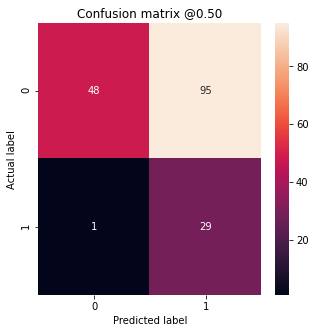

In [518]:
test_matrix['STACK'] = (test_matrix['Logistic'] + 
                        test_matrix['SVM'] +
                        test_matrix['CatBoost'] +
                        test_matrix['LGBM'] +
                        # test_matrix['h2o_XGB'] +
                        # test_matrix['h2o_GBM'] +
                        # test_matrix['h2o_RF'] +
                        test_matrix["XGB"] + 
                        test_matrix["RF"])
# Определил признак "Стэк", если он больше или равен 1 = 1, иначе = 0
test_matrix['STACK'] = test_matrix['STACK'].map(lambda 
                                                x: x + 1 - x 
                                                if x >= 1
                                                else 0)
plot_cm(test_matrix['Actual_labels'], test_matrix['STACK'])



---


## Глубокое обучение

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cleaned_df = df.copy()
val_features = np.array(X_val) # определяем все параметры и лейблы 
test_features = np.array(X_test)# как массивы, для более удобной работы
train_labels = np.array(Y_train)
val_labels = np.array(Y_val)
test_labels = np.array(Y_test)
train_features = np.array(X_train)
bool_train_labels = train_labels != 0
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (552,)
Validation labels shape: (138,)
Test labels shape: (173,)
Training features shape: (552, 24)
Validation features shape: (138, 24)
Test features shape: (173, 24)


In [ ]:
METRICS = [ # определяем все метрики
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
# определяем структуру нейронной сети
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          22, activation='relu', # активатор - релу
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', # валидационная площадь под РОК-кривой как критерий ранней остановки
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
model = make_model()
model.summary()
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 22)                550       
_________________________________________________________________
dropout_11 (Dropout)         (None, 22)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 23        
Total params: 573
Trainable params: 573
Non-trainable params: 0
_________________________________________________________________
Loss: 0.6168


In [ ]:
neg, pos = np.bincount(df['Ab_ind'])
initial_bias = np.log([pos/neg])
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

Loss: 0.5045


In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

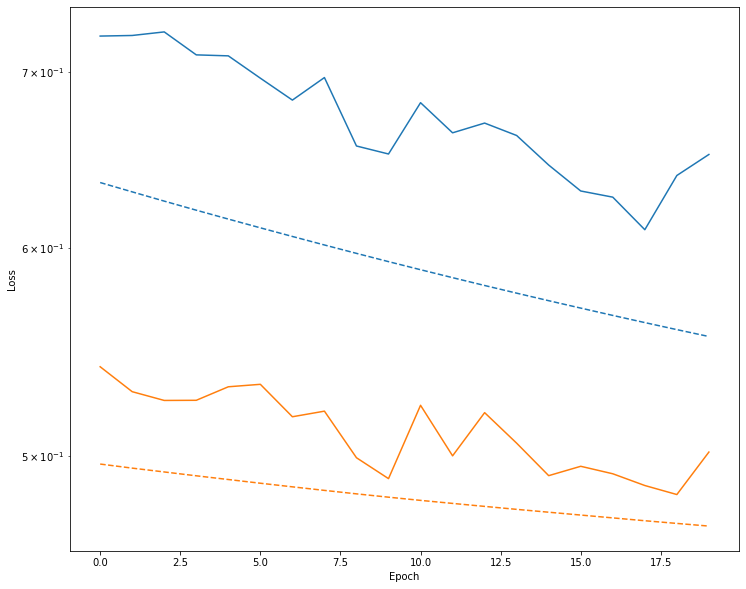

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.5407 - tp: 1.0000 - fp: 8.0000 - tn: 564.0000 - fn: 117.0000 - accuracy: 0.8188 - precision: 0.1111 - recall: 0.0085 - auc: 0.4323 - val_loss: 0.4964 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 24.0000 - val_accuracy: 0.8261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4536
Epoch 2/100
1/1 [==============================] - 0s 76ms/step - loss: 0.5290 - tp: 3.0000 - fp: 9.0000 - tn: 449.0000 - fn: 91.0000 - accuracy: 0.8188 - precision: 0.2500 - recall: 0.0319 - auc: 0.4723 - val_loss: 0.4947 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 24.0000 - val_accuracy: 0.8261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4585
Epoch 3/100
1/1 [==============================] - 0s 72ms/step - loss: 0.5249 - tp: 1.0000 - fp: 9.0000 - tn: 449.0000 - fn: 93.0000 - accuracy: 0.8152 - precision: 0.1000 - recall: 0.0106 - auc: 0.4730 - val

In [ ]:
def plot_metrics(history):
  # определяем построение графиков обучения
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

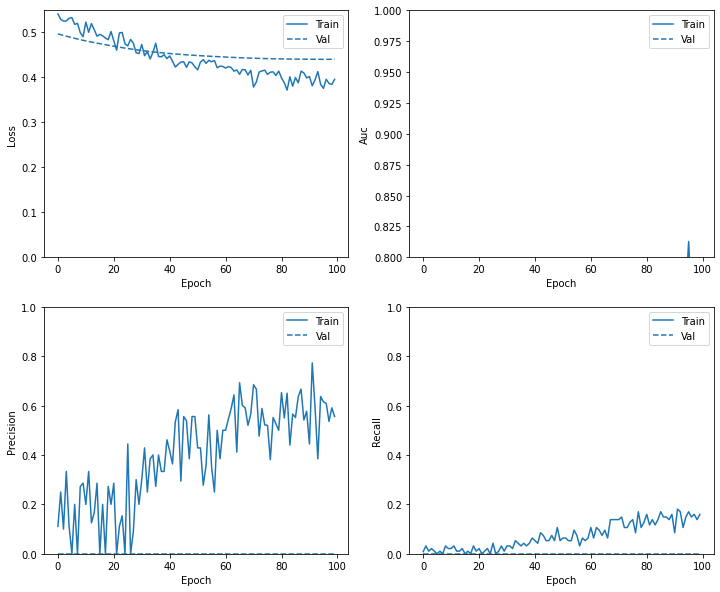

In [ ]:
plot_metrics(baseline_history)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.40667685866355896
tp :  3.0
fp :  2.0
tn :  141.0
fn :  27.0
accuracy :  0.8323699235916138
precision :  0.6000000238418579
recall :  0.10000000149011612
auc :  0.7418414950370789

Legitimate Transactions Detected (True Negatives):  141
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  27
Fraudulent Transactions Detected (True Positives):  3
Total Fraudulent Transactions:  30


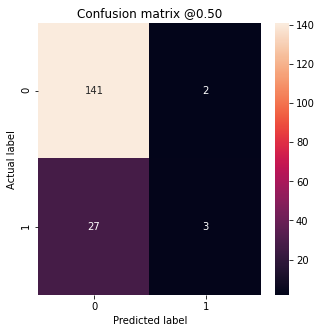

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

Итого, первое приближение. Т.к. имеет место дисбаланс в таргете, стандартные настройки работают не так как хотелось бы

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

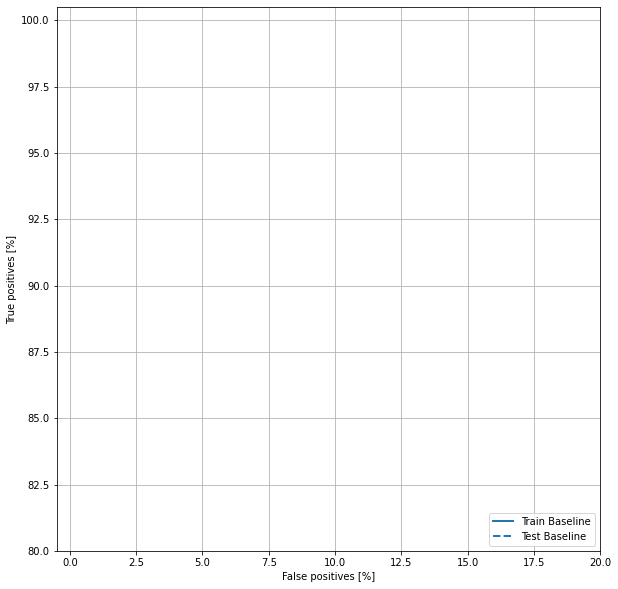

In [ ]:
import sklearn
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(df['Ab_ind'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

Examples:
    Total: 863
    Positive: 148 (17.15% of total)



In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # определил веса. Экспериментировал с разными вариантами, но
    # сначительно снизить количество ложнонеративных значений менее 6 не удалось
    class_weight=class_weight) 

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.2044 - tp: 4.0000 - fp: 10.0000 - tn: 591.0000 - fn: 120.0000 - accuracy: 0.8207 - precision: 0.2857 - recall: 0.0323 - auc: 0.4988 - val_loss: 0.4960 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 24.0000 - val_accuracy: 0.8261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4545
Epoch 2/100
1/1 [==============================] - 0s 62ms/step - loss: 1.1553 - tp: 3.0000 - fp: 10.0000 - tn: 448.0000 - fn: 91.0000 - accuracy: 0.8170 - precision: 0.2308 - recall: 0.0319 - auc: 0.4705 - val_loss: 0.4940 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 24.0000 - val_accuracy: 0.8261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4523
Epoch 3/100
1/1 [==============================] - 0s 77ms/step - loss: 1.1339 - tp: 1.0000 - fp: 10.0000 - tn: 448.0000 - fn: 93.0000 - accuracy: 0.8134 - precision: 0.0909 - recall: 0.0106 - auc: 0.4712 - 

loss :  0.5039666891098022
tp :  17.0
fp :  28.0
tn :  115.0
fn :  13.0
accuracy :  0.763005793094635
precision :  0.3777777850627899
recall :  0.5666666626930237
auc :  0.7560606002807617

Legitimate Transactions Detected (True Negatives):  115
Legitimate Transactions Incorrectly Detected (False Positives):  28
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  17
Total Fraudulent Transactions:  30


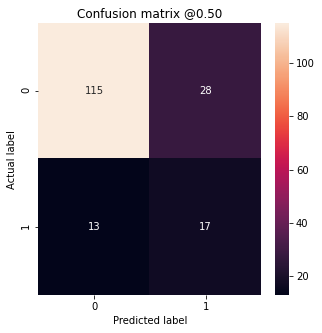

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Модель с весами классов даёт неплохой результат, но всё ещё очень большая ошибка - 9

In [ ]:
# чтобы попытаться улучшить модель, попробуем использовать бустрап-подход, а именно:
# уже существующие признаки случайным образом перенаберём, тем самым, позволим
# "лучше" нейронной сети понять закономерности взаимосвязи таргетного значения с признаками
bool_train_labels = train_labels != 0
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]
pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))
res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]
resampled_features.shape

(916, 24)

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], 
                                                         weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.8451 - tp: 329.0000 - fp: 437.0000 - tn: 751.0000 - fn: 704.0000 - accuracy: 0.4863 - precision: 0.4295 - recall: 0.3185 - auc: 0.4746 - val_loss: 0.6399 - val_tp: 7.0000 - val_fp: 29.0000 - val_tn: 85.0000 - val_fn: 17.0000 - val_accuracy: 0.6667 - val_precision: 0.1944 - val_recall: 0.2917 - val_auc: 0.4499
Epoch 2/100
1/1 [==============================] - 0s 77ms/step - loss: 0.8441 - tp: 314.0000 - fp: 432.0000 - tn: 640.0000 - fn: 662.0000 - accuracy: 0.4658 - precision: 0.4209 - recall: 0.3217 - auc: 0.4322 - val_loss: 0.6393 - val_tp: 7.0000 - val_fp: 30.0000 - val_tn: 84.0000 - val_fn: 17.0000 - val_accuracy: 0.6594 - val_precision: 0.1892 - val_recall: 0.2917 - val_auc: 0.4556
Epoch 3/100
1/1 [==============================] - 0s 83ms/step - loss: 0.8398 - tp: 354.0000 - fp: 432.0000 - tn: 601.0000 - fn: 661.0000 - accuracy: 0.4663 - precision: 0.4504 - recall: 0.3488 - auc: 0.4467 - val_loss: 0.6386 - va

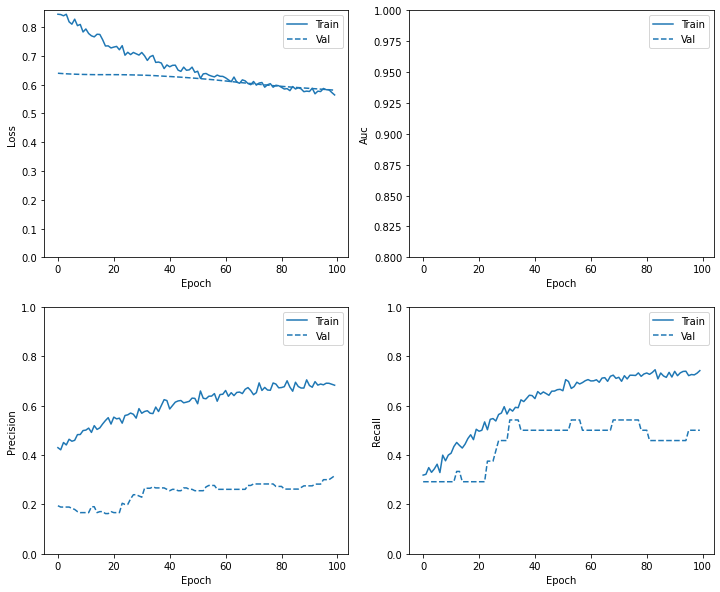

In [ ]:
plot_metrics(resampled_history)

In [ ]:
tf.random.set_seed(1234)
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds),
    class_weight={0:1, 1:6.4} # хотя и бустрап выборка в какой-то мере
    # сбалансирована, т.к. мы хотим нулевой уровень ложноотр.результата - 
    #определяем веса классов
    )

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(np.array(X_test), batch_size=BATCH_SIZE)
valid_predictions_resampled = resampled_model.predict(np.array(X_val), batch_size=BATCH_SIZE)
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Epoch 1/1000
20/20 [==============================] - 3s 75ms/step - loss: 3.3950 - tp: 4358.8095 - fp: 5071.1429 - tn: 6308.5238 - fn: 6865.0000 - accuracy: 0.4670 - precision: 0.4489 - recall: 0.3717 - auc: 0.4585 - val_loss: 0.6900 - val_tp: 12.0000 - val_fp: 56.0000 - val_tn: 58.0000 - val_fn: 12.0000 - val_accuracy: 0.5072 - val_precision: 0.1765 - val_recall: 0.5000 - val_auc: 0.5325
Epoch 2/1000
20/20 [==============================] - 1s 28ms/step - loss: 2.5689 - tp: 7064.3333 - fp: 6132.2857 - tn: 5135.5714 - fn: 4098.2857 - accuracy: 0.5403 - precision: 0.5325 - recall: 0.6149 - auc: 0.5540 - val_loss: 0.7663 - val_tp: 21.0000 - val_fp: 80.0000 - val_tn: 34.0000 - val_fn: 3.0000 - val_accuracy: 0.3986 - val_precision: 0.2079 - val_recall: 0.8750 - val_auc: 0.6243
Epoch 3/1000
20/20 [==============================] - 1s 31ms/step - loss: 2.0638 - tp: 8862.5714 - fp: 7029.5714 - tn: 4237.0476 - fn: 2301.2857 - accuracy: 0.5812 - precision: 0.5556 - recall: 0.7825 - auc: 0.6202

Нейронные сети - лидер обучения - 100% чувствительность) и отличный recall (специфичность)

In [ ]:
test_predictions_resampled = resampled_model.predict(np.array(X_test), 
                                                     batch_size=BATCH_SIZE)

In [ ]:
test_predictions_resampled = list(map(lambda x: 
                                      np.round(x +.5) if x >=.5  # определение порога "перехода" к лейблу 1
                                      else x, test_predictions_resampled))

In [ ]:
# определил предсказанное значение как признак
test_matrix['Neural_net'] = test_predictions_resampled 

## Стекинг моделей

Legitimate Transactions Detected (True Negatives):  30
Legitimate Transactions Incorrectly Detected (False Positives):  113
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  30
Total Fraudulent Transactions:  30


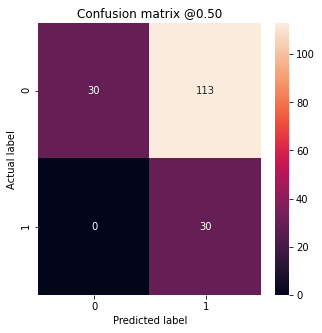

In [ ]:
test_matrix['STACK'] = (test_matrix['Logistic'] + 
                        test_matrix['SVM'] +
                        test_matrix['CatBoost'] +
                        test_matrix['LGBM'] +
                        test_matrix['h2o_XGB'] +
                        test_matrix['h2o_GBM'] +
                        test_matrix['h2o_RF'] +
                        test_matrix['Neural_net'])
# Определил признак "Стэк", если он больше или равен 1 = 1, иначе = 0
test_matrix['STACK'] = test_matrix['STACK'].map(lambda 
                                                x: x + 1 - x 
                                                if x >= 1
                                                else 0)
plot_cm(Y_test, test_matrix['STACK'])

In [ ]:
test_matrix[test_matrix['Actual_labels'] == 1]

,Logistic,SVM,CatBoost,LGBM,h2o_XGB,h2o_GBM,h2o_RF,Actual_labels,STACK,Neural_net
0,1,1,1,1,1,1,1,1,[1.0],[1.0]
2,0,0,0,0,0,0,0,1,[1.0],[1.0]
9,0,0,1,0,1,1,0,1,[1.0],[1.0]
19,1,1,1,1,1,1,0,1,[1.0],[1.0]
21,1,1,1,1,1,1,0,1,[1.0],[1.0]
22,1,1,1,1,1,1,1,1,[1.0],[1.0]
26,1,1,1,1,1,1,1,1,[1.0],[1.0]
27,0,1,1,1,0,0,0,1,[1.0],[1.0]
29,1,1,1,1,1,1,1,1,[1.0],[1.0]
38,1,1,1,1,1,1,1,1,[1.0],[1.0]


## Итог:


*   Целевой показатель ложнонегативное предсказание равен 0, что являлось принципиальным условием. Достичь удалось на бустрап-нейронной сети и стекинге
*   Лучшая модель способна снизить назначение антибиотиков с 95 % ( изначально) до 63 %, что очень неплохо.
* Поставленная цель достигнута при помощи глубокого обучения, чтобы улучшить модель необходимо больше данных
* Стекинг моделей может в какой-то мере улучшить предсказания, однако, в моём случае, модели обучения не смогли определить один случай необходимости АБ-терапии




